In [67]:
%pip install scikit-learn
%pip install seaborn
%pip install tensorflow


Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


In [68]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten,Input
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
from keras.callbacks import ModelCheckpoint
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from sklearn.metrics import confusion_matrix, classification_report
from IPython.display import display, HTML

In [69]:
import os
import re

def clean_folder_name(folder_name):
    # Remove non-alphanumeric characters (except for underscores and hyphens)
    cleaned_name = re.sub(r'[^\w\s-]', '', folder_name)
    # Replace spaces with underscores
    cleaned_name = cleaned_name.replace('batik-', '')
    return cleaned_name

def rename_folders(directory):
    for folder_name in os.listdir(directory):
        folder_path = os.path.join(directory, folder_name)
        if os.path.isdir(folder_path):
            cleaned_name = clean_folder_name(folder_name).capitalize()
            cleaned_path = os.path.join(directory, cleaned_name)
            if folder_path != cleaned_path:
                os.rename(folder_path, cleaned_path)
                print(f'Renamed: "{folder_path}" to "{cleaned_path}"')

# Replace 'your_directory_path' with the path to the directory containing folders to be cleaned
directory_path = 'data'
rename_folders(directory_path)

In [70]:
import os
from PIL import Image

def check_images(directory):
    corrupted_files = []
    for subdir, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(subdir, file)
            try:
                img = Image.open(file_path)
                img.verify()  # Verify that it is, in fact, an image
            except (IOError, SyntaxError) as e:
                print(f'Corrupted image file: {file_path}')
                corrupted_files.append(file_path)
    return corrupted_files

# Replace with the path to your image dataset
dataset_directory = 'data'
corrupted_files = check_images(dataset_directory)

# Optionally, you can remove corrupted files
for file_path in corrupted_files:
    os.remove(file_path)

In [71]:
sdir=r'data'


filepaths=[]
labels=[]
classlist=os.listdir(sdir)
for className in classlist:
    classpath=os.path.join(sdir,className)
    if os.path.isdir(classpath):
        flist=os.listdir(classpath)
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(className)                   
Fseries= pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')    
df=pd.concat([Fseries, Lseries], axis=1)
print (df['labels'].value_counts())

Bali           50
Keraton        50
Sogan          50
Sidoluhur      50
Priangan       50
Pekalongan     50
Parang         50
Betawi         50
Lasem          50
Gentongan      50
Garutan        50
Ciamis         50
Celup          50
Tambal         50
Cendrawasih    49
Ceplok         48
Sekar          47
Megamendung    46
Sidomukti      46
Kawung         45
Name: labels, dtype: int64


In [72]:
len(df[(df['labels'] == 'Megamendung')])

46

In [73]:
train_split=.8
test_split=.1
RANDOM_STATE = 1

test_valid_split=test_split/(1-train_split)
train_df, test_valid_df = train_test_split(df, train_size=train_split, shuffle=True, random_state=RANDOM_STATE)
test_df, valid_df = train_test_split(test_valid_df, train_size=test_valid_split, shuffle=True, random_state=RANDOM_STATE)
print ('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))

train_df length:  784   test_df length:  98   valid_df length:  99


In [74]:
height=224
width=224
channels=3
batch_size=64

img_shape=(height, width, channels)
img_size=(height, width)
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps=int(length/test_batch_size)
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps)

gen=ImageDataGenerator(
    rescale=1./255,
    )
train_gen=gen.flow_from_dataframe( train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)

validgen=ImageDataGenerator(rescale=1./255)
valid_gen=validgen.flow_from_dataframe( valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)

testgen=ImageDataGenerator(rescale=1./255)
test_gen=testgen.flow_from_dataframe( test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=test_batch_size)

classes=list(train_gen.class_indices.keys())
print (classes)
class_count=len(classes)



test batch size:  49   test steps:  2
Found 784 validated image filenames belonging to 20 classes.
Found 99 validated image filenames belonging to 20 classes.
Found 98 validated image filenames belonging to 20 classes.
['Bali', 'Betawi', 'Celup', 'Cendrawasih', 'Ceplok', 'Ciamis', 'Garutan', 'Gentongan', 'Kawung', 'Keraton', 'Lasem', 'Megamendung', 'Parang', 'Pekalongan', 'Priangan', 'Sekar', 'Sidoluhur', 'Sidomukti', 'Sogan', 'Tambal']


In [75]:
def show_image_samples(gen):
    test_dict=test_gen.class_indices
    classes=list(test_dict.keys())    
    images,labels=next(gen) # get a sample batch from the generator 
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i]
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show()

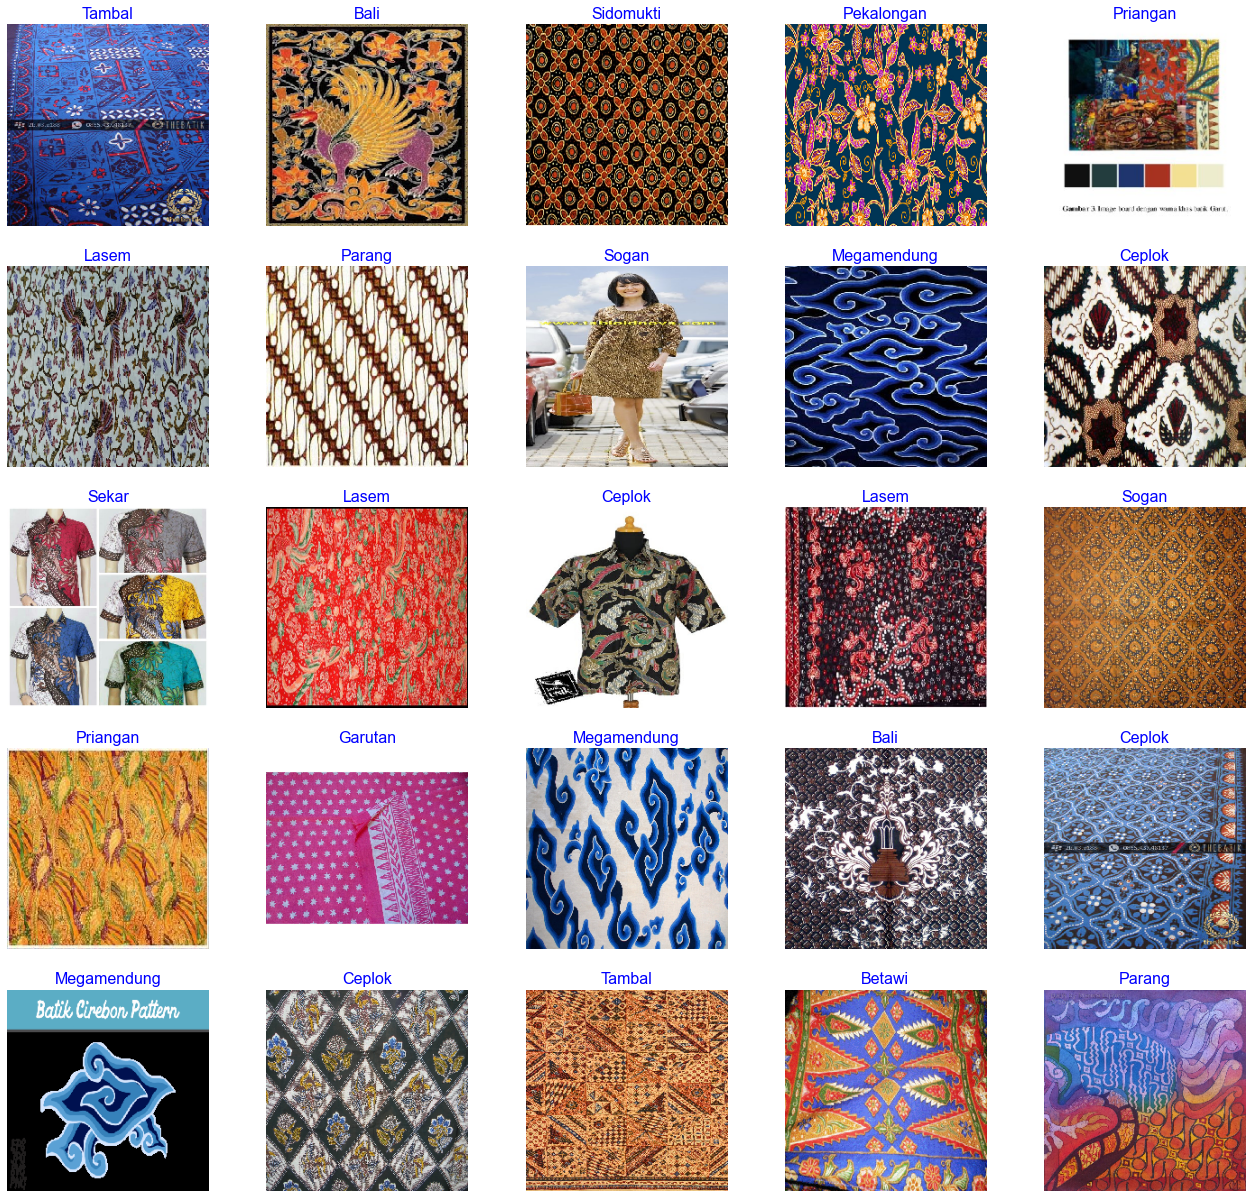

In [76]:
show_image_samples(train_gen)

In [77]:
base_model=tf.keras.applications.Xception(include_top=False, weights="imagenet",input_tensor=Input(shape=(224,224,3))) 

In [78]:
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

In [79]:
base_model.trainable = False

In [80]:
model_name='Batik CNN'
print("Building model with", base_model)
model = tf.keras.Sequential([
            # Note the input shape is the desired size of the image 128x128 with 3 bytes color
            # This is the first convolution
            base_model,
            tf.keras.layers.Conv2D(filters=32, padding='same', kernel_size=3, activation='relu', strides=1),
            tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
            tf.keras.layers.Dropout(rate=0.5),

            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(20, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.001), loss='categorical_crossentropy', metrics='accuracy')

Building model with <keras.engine.functional.Functional object at 0x000002A10B579A20>


In [81]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 conv2d_15 (Conv2D)          (None, 7, 7, 32)          589856    
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 3, 3, 32)         0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 3, 3, 32)          0         
                                                                 
 flatten_3 (Flatten)         (None, 288)               0         
                                                                 
 dense_3 (Dense)             (None, 20)                5780      
                                                      

In [82]:
epochs =100

history=model.fit(x=train_gen, epochs=epochs, validation_data=valid_gen)

Epoch 1/100
13/13 [==============================] - 51s 4s/step - loss: 3.0972 - accuracy: 0.0638 - val_loss: 2.9064 - val_accuracy: 0.0606
Epoch 2/100
13/13 [==============================] - 45s 4s/step - loss: 2.9001 - accuracy: 0.0918 - val_loss: 2.9182 - val_accuracy: 0.1111
Epoch 3/100
13/13 [==============================] - 47s 4s/step - loss: 2.8394 - accuracy: 0.1173 - val_loss: 2.8475 - val_accuracy: 0.1313
Epoch 4/100
13/13 [==============================] - 101s 8s/step - loss: 2.7557 - accuracy: 0.1480 - val_loss: 2.8118 - val_accuracy: 0.1717
Epoch 5/100
13/13 [==============================] - 53s 4s/step - loss: 2.6604 - accuracy: 0.1888 - val_loss: 2.8444 - val_accuracy: 0.1616
Epoch 6/100
13/13 [==============================] - 49s 4s/step - loss: 2.5457 - accuracy: 0.2015 - val_loss: 2.7853 - val_accuracy: 0.1717
Epoch 7/100
13/13 [==============================] - 50s 4s/step - loss: 2.4155 - accuracy: 0.2423 - val_loss: 2.7960 - val_accuracy: 0.1717
Epoch 8/100


In [83]:
def print_in_color(txt_msg,fore_tupple,back_tupple,):
    #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple 
    #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m' 
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) # returns default print color to back to black
    return

In [84]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    #plt.style.use('fivethirtyeight')
    plt.show()


In [85]:
def print_info( test_gen, preds, print_code, save_dir, subject ):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames 
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key             # dictionary {integer of class number: string of class name}
    # store new_dict as a text fine in the save_dir
    classes=list(new_dict.values())     # list of string of class names
    dict_as_text=str(new_dict)
    dict_name= subject + '-' +str(len(classes)) +'.txt'  
    dict_path=os.path.join(save_dir,dict_name)    
    with open(dict_path, 'w') as x_file:
        x_file.write(dict_as_text)    
    errors=0      
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)        
        true_index=labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)            
            errors=errors + 1
        y_pred.append(pred_index)    
    if print_code !=0:
        if errors>0:
            if print_code>errors:
                r=errors
            else:
                r=print_code           
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print_in_color(msg, (0,255,0),(55,65,80))
            for i in range(r):                
                split1=os.path.split(error_list[i])                
                split2=os.path.split(split1[0])                
                fname=split2[1] + '/' + split1[1]
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(fname, pred_class[i],true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255,255,255), (55,65,60))
                #print(error_list[i]  , pred_class[i], true_class[i], prob_list[i])               
        else:
            msg='With accuracy of 100 % there are no errors to print'
            print_in_color(msg, (0,255,0),(55,65,80))
    if errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in new_dict.items():        
            count=error_indices.count(key) 
            if count!=0:
                plot_bar.append(count) # list containg how many times a class c had an error
                plot_class.append(value)   # stores the class 
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Errors by Class on Test Set')
    y_true= np.array(labels)        
    y_pred=np.array(y_pred)
    if len(classes)<= 30:
        # create a confusion matrix 
        cm = confusion_matrix(y_true, y_pred )        
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)

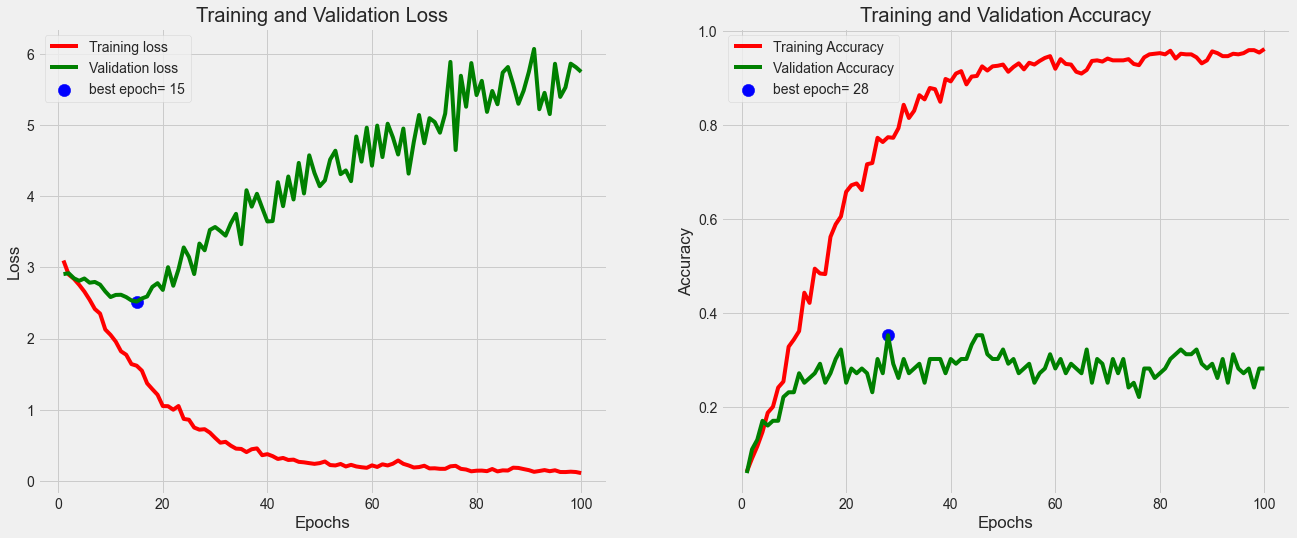

2/2 [==============================] - 6s 3s/step - loss: 6.1816 - accuracy: 0.3469
accuracy on the test set is 34.69 %



In [86]:
tr_plot(history,0)
save_dir=r'./'
subject='Batik CNN'
acc=model.evaluate( test_gen, batch_size=test_batch_size, verbose=1, steps=test_steps, return_dict=False)[1]*100
msg=f'accuracy on the test set is {acc:5.2f} %'
print_in_color(msg, (0,255,0),(55,65,80))
save_id=str (model_name +  '-' + subject +'-'+ str(acc)[:str(acc).rfind('.')+3] + '.h5')
save_loc=os.path.join(save_dir, save_id)
model.save(save_loc)

2/2 [==============================] - 7s 3s/step


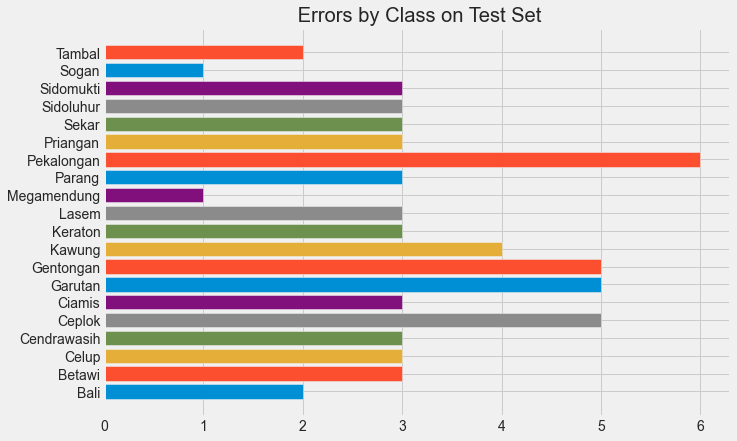

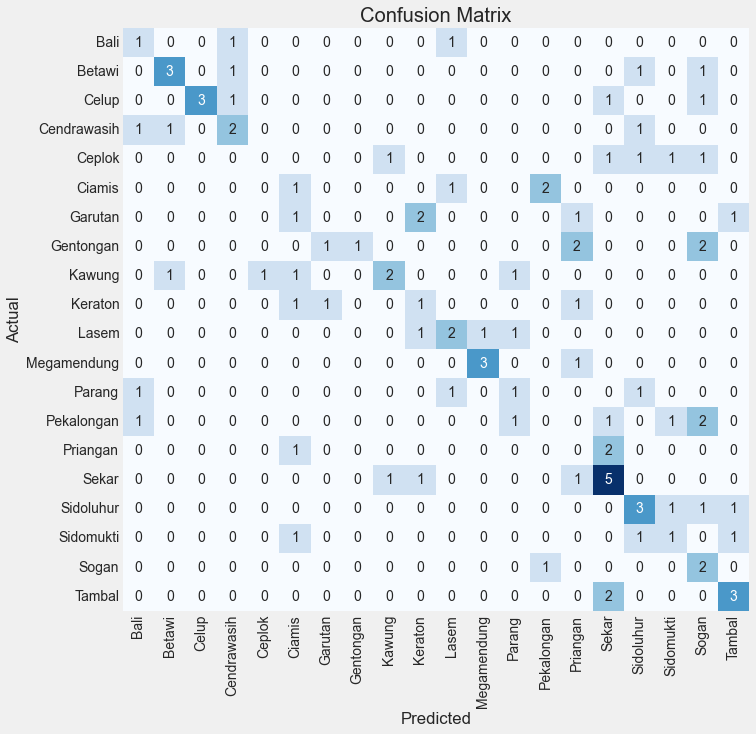

Classification Report:
----------------------
               precision    recall  f1-score   support

        Bali       0.25      0.33      0.29         3
      Betawi       0.60      0.50      0.55         6
       Celup       1.00      0.50      0.67         6
 Cendrawasih       0.40      0.40      0.40         5
      Ceplok       0.00      0.00      0.00         5
      Ciamis       0.17      0.25      0.20         4
     Garutan       0.00      0.00      0.00         5
   Gentongan       1.00      0.17      0.29         6
      Kawung       0.50      0.33      0.40         6
     Keraton       0.20      0.25      0.22         4
       Lasem       0.40      0.40      0.40         5
 Megamendung       0.75      0.75      0.75         4
      Parang       0.25      0.25      0.25         4
  Pekalongan       0.00      0.00      0.00         6
    Priangan       0.00      0.00      0.00         3
       Sekar       0.42      0.62      0.50         8
   Sidoluhur       0.38      0.50 

In [87]:
print_code=0
preds=model.predict(test_gen) 
print_info( test_gen, preds, print_code, save_dir, subject )  

In [88]:
str(acc)[:str(acc).rfind('.')+3]

'34.69'